In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import hdf5plugin
import h5py as h5
import numba

In [86]:
def trc(matr):
    """Calculate the two-time correlation function."""
    meanmatr = np.mean(matr, axis=1)
    meanmatr[meanmatr <= 0] = 1.0
    tmp, lenmatr = np.shape(matr)
    meanmatr.shape = 1, tmp
    trcm = np.dot(matr, matr.T) / lenmatr / np.dot(meanmatr.T, meanmatr)
    return trcm

def crosstrc(matr1, matr2):
    """Calculate the cross-two-time correlation function."""
    meanmatr1 = np.mean(matr1, axis=1)
    meanmatr1[meanmatr1 <= 0] = 1.0
    meanmatr2 = np.mean(matr2, axis=1)
    meanmatr2[meanmatr2 <= 0] = 1.0
    tmp, lenmatr = np.shape(matr1)
    meanmatr1 = meanmatr1.reshape(1, tmp)
    meanmatr2 = meanmatr2.reshape(1, tmp)
    trcm = np.dot(matr1, matr2.T) / lenmatr / np.dot(meanmatr1.T, meanmatr2)
    return trcm

def vartrc(ttc):
    """Calculate the variance of the two-time correlation function."""
    # pc0 = [1.0, 0.1]
    n, tmp = np.shape(ttc)
    vtmp = []
    for it in range(1, n - 1):
        # ydata=diag(ttc,it)
        # xdata=arange(1,len(ydata)+1)
        # p1,success=leastsq(errfuncc,pc0,args=(xdata,ydata))
        # vtmp.append(var(ydata/(p1[0]+p1[1]*xdata)))
        vtmp.append(np.var(np.diag(ttc, it)))
    return vtmp

def recurf(ll):
    """Helper function used for calculating the two-time correlation function."""
    # global l, y, v
    y[ll + 1].append((y[ll][0] + y[ll][1]) * 0.5)
    y[ll] = []
    v[ll + 1].append(vartrc(y[ll + 1][-1]))
    if l[ll + 1] == 1:
        recurf(ll + 1)
    else:
        l[ll + 1] += 1
    l[ll] = 0

def calc_twotime_cf(ttdata, tt_max_images=5000, crossttdata=None):
    """Calculate two-time correlation function of a large data set.

    Args:
        ttdata (list): list of arrays each of shape (nimages, npixels).
    """

    crossdata_avail = False if crossttdata is None else True
    nbins = len(ttdata)
    output_ttc = []
    output_z = []
    for ibin in range(nbins):
        data = ttdata[ibin]

        if crossdata_avail:
            cdata = crossttdata[ibin]

        nf, lind = data.shape
        if nf > tt_max_images:
            ttchunk = nf // tt_max_images
            nfnew = ttchunk * tt_max_images
            print(
                "Reducing two-time correlation data from "
                "{} to {} images by rebinning.".format(nf, tt_max_images)
            )
            data = np.mean(data[:nfnew].reshape(ttchunk, -1, lind, order="F"), 0)

        lind2 = lind // 16
        l = np.zeros(5)
        y = []
        v = []
        for i in range(5):
            y.append([])
            v.append([])

        ib = 0
        for i in range(16):
            ie = ib + lind2

            if not crossdata_avail:
                y[0].append(trc(data[:, ib:ie]))
            else:
                c1 = crosstrc(data[:, ib:ie], cdata[:, ib:ie])
                c2 = crosstrc(cdata[:, ib:ie], data[:, ib:ie])
                y[0].append((c1 + c2) / 2.0)

            v[0].append(vartrc(y[0][-1]))
            if l[0] == 1:
                recurf(0)
            else:
                l[0] += 1
            ib += lind2

        vm = []
        for i in range(4, -1, -1):
            vm.append(np.mean(v[i], 0))
        vm = np.array(vm)

        del data
        del v

        ttcf = y[4][-1]

        dia1 = np.mean(np.diag(ttcf, 1))
        t = np.arange(np.shape(ttcf)[0])
        ttcf[t, t] = dia1

        N = np.array([1, 2, 4, 8, 16]) / float(lind)
        z = vm.T / N
        # p0=[0,1]
        # it=range(len(ttcf[1:,0]))
        # p1=zeros((len(ttcf[1:,0]),len(p0)+1))
        # p1[:,0]=(asfarray(it)+1.0)*dt
        # xdata=ttcf[0,:]
        # for i in it:
        #    ydata=ttcf[i+1,:]
        #    p1[i,1:], success = leastsq(errfunc, p0, args=(xdata,ydata))

        output_ttc.append(ttcf)
        output_z.append(z)

    return output_ttc, output_z


In [2]:
def ttc_to_g2(ttc, time=None):
    """Calculate g2 function from TTC

    Args:
        cor (np.ndarray): sqaure correlation matrix (TTC)
        time (np.ndarray, optional): 1D vector of lag times. Defaults to None.
            If None, np.arange will be used for evenly spaced time bins.
    """

    ntimes = ttc.shape[0]
    if time is None:
        time = np.arange(ntimes) + 1

    # initialize output array
    tau = np.ones(ntimes)
    g2 = np.ones(ntimes)
    g2_err = np.ones(ntimes)
    tau = time
    for i in range(1, ntimes):
        dia = np.diag(ttc, k=i)
        ind = np.where(np.isfinite(dia))
        if len(dia[ind]):
            g2[i-1] = np.mean(dia[ind])
            g2_err[i-1] = np.std(dia[ind])
    g2_err *= np.sqrt(1.0 / (ntimes))
    return tau, g2[:-1], g2_err[:-1]

In [3]:
with h5.File('cmake-build-release/ttc.hdf5') as cpp_file:
    ttc = cpp_file['ttc'][()]
    dt = cpp_file['dt'][()]
    time = np.linspace(dt, ttc.shape[0]*dt, ttc.shape[0])
    cpp_img = cpp_file['avg_img'][()]
    # cpp_roi = cpp_file['waxs/roi_data'][()]


In [4]:
time

array([5.0000e-04, 1.0000e-03, 1.5000e-03, ..., 2.5005e+00, 2.5010e+00,
       2.5015e+00])

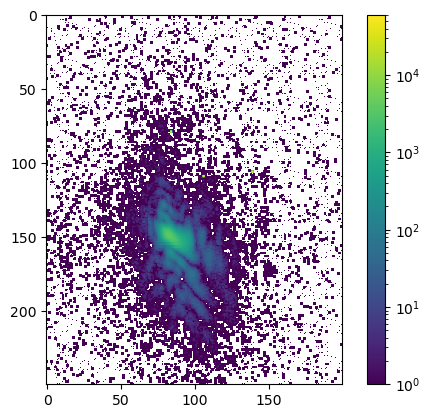

In [5]:
plt.imshow(cpp_img, norm=LogNorm())
plt.colorbar()

In [11]:
with h5.File('data/scan_000186_eiger500k.hdf5') as original_file:
    original_image = original_file['/entry/instrument/Eiger/data'][:5000, 100:350, 600:800]
    sqnc = original_file['/entry/instrument/Eiger/sequence_number'][:5000]

In [38]:
data = original_image.reshape(original_image.shape[0], original_image.shape[1]*original_image.shape[2])

In [88]:
_ttc = trc(data[:, 0:100])

In [90]:
np.argwhere(_ttc>0)

array([[  13,   13],
       [1159, 1159],
       [4913, 4913]])

In [39]:
nf, lind = data.shape
nf, lind

(5000, 50000)

In [43]:
lind2 = lind // 16
l = np.zeros(5)
y = []
v = []
for i in range(5):
    y.append([])
    v.append([])
y

[[], [], [], [], []]

In [46]:
ib = 0
for i in range(2):
    ie = ib + lind2
    print(ib, ie, y)
    y[0].append(trc(data[:, ib:ie]))
    v[0].append(vartrc(y[0][-1]))
    if l[0] == 1:
        recurf(0)
    else:
        l[0] += 1
    ib += lind2

0 3125 [[], [], [], [], []]
3125 6250 [[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])], [], [], [], []]


KeyboardInterrupt: 

In [50]:
y[0][0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
for i in range(10):
    num = (original_image[sqnc[i]] * original_image[sqnc[i+1]]).mean()
    denom = original_image[sqnc[i]].mean() * original_image[sqnc[i+1]].mean()
    print(num / denom, num, denom)

3.7482239007764526e-05 0.00058 15.4739955604
2.9731374017116025e-05 0.00046 15.4718715568
3.101978381157485e-05 0.00048 15.4739956576
3.35992990507202e-05 0.00052 15.476513340799999
3.230866090297498e-05 0.0005 15.4757265088
1.938943503593136e-05 0.0003 15.472343544
3.360698711887459e-05 0.00052 15.472972872
4.2648299526877194e-05 0.00066 15.4754118528
2.068143323440012e-05 0.00032 15.4728154656
3.748414489273485e-05 0.00058 15.4732087836


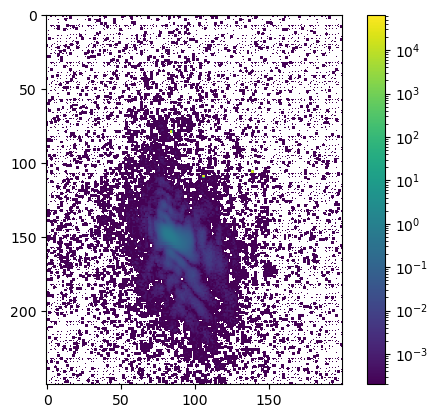

In [135]:
plt.imshow(original_image, norm=LogNorm())
plt.colorbar()

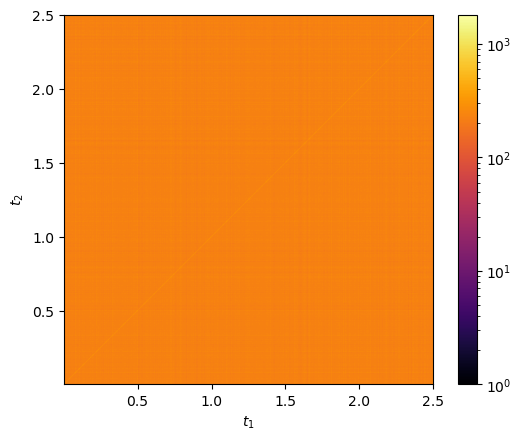

In [136]:
fig, ax = plt.subplots()
ttc_plot = ax.imshow(
    ttc,
    norm=LogNorm(),
    origin='lower',
    cmap='inferno',
    extent = [time.min(), time.max(), time.min(), time.max()],
)
# ax_x = ax.secondary_yaxis('right')
# ax_x.set_yticks(np.arange(0,ttc_submat.shape[0]))
# ax_y = ax.secondary_xaxis('top')
# ax_y.set_xticks(np.arange(0,ttc_submat.shape[0]))
ax.set_xlabel('$t_1$')
ax.set_ylabel('$t_2$')
fig.colorbar(ttc_plot)
plt.show()

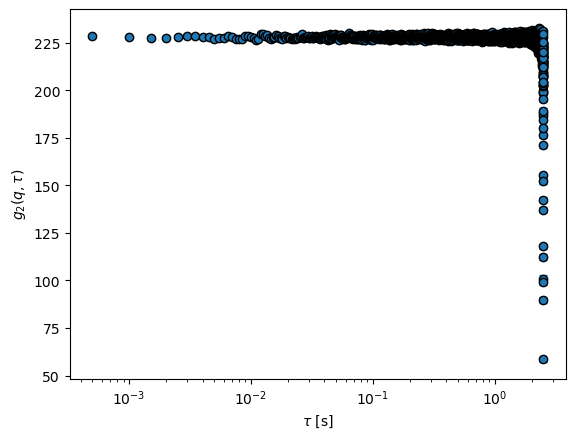

In [137]:
_, g2, g2_err = ttc_to_g2(ttc, 500)
plt.errorbar(time[:-1], g2, yerr=g2_err, marker='o', markeredgecolor='k', capsize=3, linestyle='')
plt.xscale('log')
# plt.xlim(time[0]-0.01,0.1)
plt.ylabel(r'$g_2(q, \tau)$')
plt.xlabel(r'$\tau$ [s]')
plt.show()